# Earnings Spatial Regression

_Everything is related to everything else. But near things are more related than distant things_ - Waldo Tobler

Earnings surprises occur when a company reports earnings that are significantly different from what analysts had predicted. Spatial regression models help analyze how these surprises propagate through interconnected firms, particularly when firms operate within related industries. By using text-based firm similarity scores as spatial weights, we examine how earnings surprises cluster and spread across firms with similar product market characteristics.

In [1]:
# By: Terence Lim, 2020-2025 (terence-lim.github.io)
from pandas import DataFrame, Series
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import io
import zipfile
from libpysal.weights import W
from esda.moran import Moran
import spreg
import networkx as nx
import statsmodels.formula.api as smf
import warnings
import requests
from finds.database import SQL, RedisDB
from finds.structured import BusDay, CRSP, PSTAT
from finds.readers import Alfred
from finds.recipes import remove_outliers
from finds.utils import Store
from secret import credentials, paths, CRSP_DATE
#pd.set_option('display.max_rows', 50)
VERBOSE = 0
#%matplotlib qt

In [2]:
# open connections
sql = SQL(**credentials['sql'], verbose=VERBOSE)
user = SQL(**credentials['user'], verbose=VERBOSE)
rdb = RedisDB(**credentials['redis'])
bd = BusDay(sql, verbose=VERBOSE)
crsp = CRSP(sql, bd, rdb=rdb, verbose=VERBOSE)
pstat = PSTAT(sql, bd, verbose=VERBOSE)
store = Store(paths['scratch'])

In [3]:
LAST_DATE = CRSP_DATE
scheme = 'tnic3'
# fetch NBER recession dates
alf = Alfred(api_key=credentials['fred']['api_key'], verbose=VERBOSE)
vspans = alf.date_spans('USREC')  # to indicate recession periods in the plots

In [4]:
# create table to lookup gvkey by permno
lookup = pstat.build_lookup(source='lpermno', target='gvkey', fillna=0)

## Earnings surprise

An earnings surprise, or unexpected earnings, is the difference between the reported earnings and expected earnings. The unexpected earnings per share when scaled by the stock price, at the fiscal end date, is more comparable across stocks of different market size and price levels.

In [5]:
# require and get actual quarterly earnings, reindex by (permno, rebaldate)
df = pstat.get_linked(dataset='quarterly',
                      fields=['prccq', 'cshoq', 'ibq'],
                      date_field='datadate',
                      where=f"datadate <= {LAST_DATE}")
# store['fund'] = df

In [6]:
fund = df.dropna(subset=['ibq'])\
         .sort_values(['permno', 'datadate', 'cshoq'])\
         .drop_duplicates(['permno', 'datadate'])\
         .reset_index()
fund['rebaldate'] = bd.endmo(fund['datadate'])

# calculate sue with lag(4) difference in compustat quarterly and price
lag = fund.shift(4, fill_value=0)
keep = ((lag['permno'] == fund['permno']) &
        (fund['prccq'] > 5)).values
fund.loc[keep, 'sue'] = ((fund.loc[keep, 'ibq'] - lag.loc[keep, 'ibq']) /
                         abs(fund.loc[keep, 'prccq'] * fund.loc[keep, 'cshoq']))
print('with pstat earnings', np.sum(~fund['sue'].isna()))

with pstat earnings 740370


In [7]:
sue = fund.loc[~fund['sue'].isna(), ['permno', 'rebaldate', 'sue']]\
          .reset_index(drop=True)
sue['rebaldate'] //= 100

## Spatial dependence models


### Moran's I

Moran's I is a statistical measure that quantifies spatial autocorrelation, assessing whether earnings surprises exhibit clustering across firms. The expected value of Moran's I under a random distribution is:

$$E(I) = \frac{-1}{N-1}$$

A positive Moran’s I value suggests earnings surprises tend to cluster among similar firms, while a negative value indicates dispersion. This test provides a conservative benchmark by comparing results to a null hypothesis of zero spatial dependence, which helps identify significant deviations from randomness.

More details: [Moran's I (Wikipedia)](https://en.wikipedia.org/wiki/Moran%27s_I)

### Spatial lag model

The **spatial lag model** extends traditional regression analysis by incorporating the influence of neighboring observations. The model is expressed as:

The **spatial lag model** extends traditional regression analysis by incorporating the influence of neighboring observations. The model is expressed as:

$$Y_i = \beta X_i + \rho WY_j + \epsilon_i$$

where:

- $Y_i$ is the dependent variable (e.g., earnings surprise) for firm $i$,
- $Y_j$ represents the corresponding values from other firms,
- $W$ is a matrix of spatial weights that assigns higher values to firms that are more closely related to firm $i$,
- $
ho$ captures the strength of spatial dependence, and
- $\epsilon_i$ is the error term.

Further reading:
- [Spatial Lag Model (Lost Stats)](https://lost-stats.github.io/Geo-Spatial/spatial_lag_model.html)
- [spreg.ML_Lag (PySAL)](https://pysal.org/spreg/generated/spreg.ML_Lag.html)
  

We use text-based firm similarity scores as spatial weights:  the TNIC-3 scores, developed by Hoberg and Phillips (2016), are derived from product descriptions in 10-K filings. Their methodology constructs firm-by-firm similarity scores using word vectors while filtering out common words and focusing on nouns and proper nouns, excluding geographic terms.

In [8]:
# Retrieve TNIC linkages from Hoberg and Phillips website
root = 'https://hobergphillips.tuck.dartmouth.edu/idata/'
source = root + scheme + '_data.zip'
if source.startswith('http'):
    response = requests.get(source)
    source = io.BytesIO(response.content)
with zipfile.ZipFile(source).open(scheme + "_data.txt") as f:
    tnic_df = pd.read_csv(f, sep='\s+')
store['spatial'] = (fund, tnic_df)
tnic_df['year'].value_counts().sort_index().to_frame()


,count
year,
1988,311616
1989,640221
1990,663746
1991,699152
1992,788029
1993,940368
1994,1027776
1995,1095721
1996,1197991


In [16]:
# Compute quarterly spatial regression coefficients
out = dict(moran={}, rho={}, beta={})
years = range(1988, 2024)
for year in tqdm(years):
    tnic = tnic_df[tnic_df.year == year].dropna()  # extract the year's tnic links

    # populate graph from tnic edges, with gvkey as nodes
    graph = nx.Graph()
    graph.add_edges_from(tnic[['gvkey1', 'gvkey2']].values)
    graph.remove_edges_from(nx.selfloop_edges(graph))   # not necessary

    for qtr in [12, 103, 106, 109]:   # loop over next four quarters of sue
        rebaldate = year*100 + qtr

        # extract sue's with in this fiscal quarter
        y = sue[sue['rebaldate'] == rebaldate].set_index('permno')[['sue']]

        # lookup gvkeys
        y['gvkey'] = lookup(y.index, date=bd.endmo(rebaldate))

        # merge in stock returns in the quarter
        y = y.join(crsp.get_ret(bd.begmo(rebaldate, months=-2),
                                bd.endmo(rebaldate)),
                   how='left')\
             .set_index('gvkey')
            
        # require available and not outlier
        y = remove_outliers(y[~y.index.duplicated() & (y.index > 0)]).dropna()

        # extract subgraph, its nodes and their neighbors
        G = graph.subgraph(y.index)
        G = G.subgraph(max(nx.connected_components(G), key=len)) 
        neighbors = {node: list(G.neighbors(node)) for node in G.nodes()}
        w = W(neighbors)
        y = y.loc[sorted(neighbors.keys())]

        # compute Moran's I and spatial lag model of sue on past stock returns
        mi = Moran(y['sue'].values,  w)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            spatial = spreg.ML_Lag(y=y['sue'].values, x=y[['ret']].values, w=w,
                                   name_x=['ret'], name_y='sue', name_w=scheme,
                                   name_ds=str(rebaldate))
        out['moran'][rebaldate] = mi.I
        out['rho'][rebaldate] = float(spatial.rho)
        out['beta'][rebaldate] = float(spatial.betas[1][0])

100%|██████████| 36/36 [17:49<00:00, 29.70s/it]


In [17]:
# Show latest quarter's results
print(spatial.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :      202409
Weights matrix      :       tnic3
Dependent Variable  :         sue                Number of Observations:        2177
Mean dependent var  :     -0.0003                Number of Variables   :           3
S.D. dependent var  :      0.0242                Degrees of Freedom    :        2174
Pseudo R-squared    :      0.0204
Spatial Pseudo R-squared:  0.0040
Sigma-square ML     :       0.001                Log likelihood        :    5026.680
S.E of regression   :       0.024                Akaike info criterion :  -10047.360
                                                 Schwarz criterion     :  -10030.303

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

In [18]:
# Show spatial regression results
ols = spreg.OLS(y=y['sue'].values, x=y[['ret']].values, w=w,
                robust='white', spat_diag=True, moran=True,
                name_x=['ret'], name_y='sue', name_w=scheme,
                name_ds=str(rebaldate))
print(ols.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :      202409
Weights matrix      :       tnic3
Dependent Variable  :         sue                Number of Observations:        2177
Mean dependent var  :     -0.0003                Number of Variables   :           2
S.D. dependent var  :      0.0242                Degrees of Freedom    :        2175
R-squared           :      0.0042
Adjusted R-squared  :      0.0037
Sum squared residual:       1.273                F-statistic           :      9.0806
Sigma-square        :       0.001                Prob(F-statistic)     :    0.002613
S.E. of regression  :       0.024                Log likelihood        :    5014.003
Sigma-square ML     :       0.001                Akaike info criterion :  -10024.005
S.E of regression ML:      0.0242                Schwarz criterion     :  -10012.634

White Standard Errors
-------------------------------------------------------

In [19]:
# Show Moran's I
print(f"Quarter: {rebaldate}") 
DataFrame({"Moran's I": mi.I, "Expected": mi.EI, "p_norm": mi.p_norm},
          index=["under assumption of normality"])

Quarter: 202409


,Moran's I,Expected,p_norm
under assumption of normality,0.051519,-0.00046,1.401822e-07


In [20]:
# Show ordinary regression results
results = DataFrame(out)
results.index = bd.to_datetime(bd.endmo(results.index))
summary = dict()
for col in results.columns:
    model = smf.ols(f'{col} ~ 1', data=results).fit()
    robust = smf.ols(f'{col} ~ 1', data=results)\
                .fit(cov_type='HAC', cov_kwds={'maxlags': 6})
    summary[col] = dict(mean=float(model.params.iloc[0]),
                        stderr=float(model.bse.iloc[0]),
                        t=float(model.tvalues.iloc[0]),
                        nw_stderr=float(robust.bse.iloc[0]),
                        nw_t=float(robust.tvalues.iloc[0]))
print("Tests of statistical significance")
DataFrame(summary)

Tests of statistical significance


,moran,rho,beta
mean,0.053146,0.224189,0.011726
stderr,0.002577,0.009331,0.000690
t,20.623401,24.027336,17.006094
nw_stderr,0.004606,0.017202,0.000952
nw_t,11.538987,13.032706,12.323118


To track changes over time, we plot the strength of spatial coefficients on a quarterly basis. Additionally, we highlight U.S. recession periods in blue, as times of economic stress may amplify the strength of linkages.


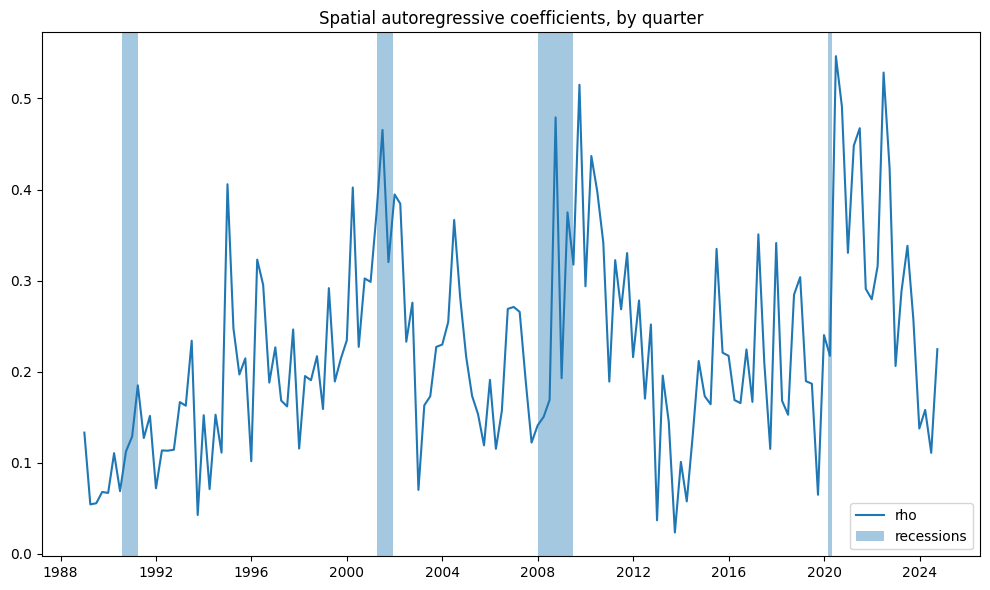

In [21]:
# Visualize autoregressive coefficients by quarter
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(results['rho'])
ax.set_title("Spatial autoregressive coefficients, by quarter")
for a,b in vspans:
    if a >= min(results.index):
        ax.axvspan(a, min(b, max(results.index)), alpha=0.4)
plt.legend(['rho', 'recessions'])
plt.tight_layout()
plt.show()